## Training a GAN on Fashion MNIST

#### Setting for hot reloading of modules

In [1]:
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import lightning as L
import torchvision
import torchvision.transforms as transforms
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

from src.models.discriminator import Discriminator
from src.models.generator import Generator
from src.train.wrapper.gan_wrapper import GANWrapper
from src.utils.constants import Paths
from src.utils.helpers import detect_device, matplotlib_imshow

#### Setting up the data

In [3]:
BATCH_SIZE = 128

#### Downloading and preparing the data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST(Paths.DATA_DIR, train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST(Paths.DATA_DIR, train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


#### Defining the model hyperparameters

In [5]:
z_dim = 128
num_classes = len(classes)
generator_input_dim = z_dim + num_classes
input_channels = 1
discriminator_input_dim = input_channels + num_classes

#### Visualizing the data

torch.Size([3, 482, 242])
Sneaker  Sandal  Shirt  Dress


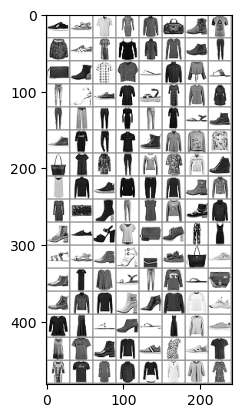

In [6]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

#### Defining the model

In [8]:
generator = Generator(generator_input_dim, input_channels)
discriminator = Discriminator(discriminator_input_dim)

gan_wrapper = GANWrapper(generator, discriminator, z_dim, num_classes, display_every_n_steps=10)

#### Defining the training parameters

In [9]:
logger = TensorBoardLogger(Paths.LOGS_DIR, name='gan_training.logs')
checkpoint_callback = ModelCheckpoint(dirpath=Paths.MODEL_CHECKPOINT_DIR,
                                      filename='gan-{epoch:02d}-{val_generator_loss:.2f}', save_top_k=3,
                                      monitor='val_generator_loss')

In [10]:
# %load_ext tensorboard
# %tensorboard --logdir /logs/gan_training.logs

#### Training the model

In [11]:
trainer = L.Trainer(default_root_dir=Paths.MODEL_CHECKPOINT_DIR, max_epochs=10000, callbacks=[checkpoint_callback],
                    logger=logger, accelerator=detect_device(), enable_checkpointing=True, log_every_n_steps=100)

trainer.fit(gan_wrapper, train_dataloaders=training_loader, val_dataloaders=validation_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | generator     | Generator         | 1.2 M 
1 | discriminator | Discriminator     | 672 K 
2 | criterion     | BCEWithLogitsLoss | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.577     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\gabriel\miniconda3\envs\data-augmentation-ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\gabriel\miniconda3\envs\data-augmentation-ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\gabriel\miniconda3\envs\data-augmentation-ml\Lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
